In [1]:
import matplotlib.pylab as plt
import padasip as pa 
import numpy as np

In [2]:
import operator
import math
import random

import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import pandas as pd

import psutil
USE_MULTIPROCESSING = psutil.cpu_count() - 1


if USE_MULTIPROCESSING > 0:
    import multiprocessing as mp
    from multiprocessing import Pool
    
print('Using ' + str(USE_MULTIPROCESSING) + ' parallel tasks')
p = Pool(USE_MULTIPROCESSING)

import time

Using 3 parallel tasks


In [3]:
from scipy import fftpack

def fft_get_ith_component(series, i, get_parameters = False):
    n = len(series)
    Y = np.fft.fft(series)
    np.put(Y, list(range(0, i)) + list(range(i+1,n)) , 0.0)
    ifft = np.fft.ifft(Y)
    
    if get_parameters:
        freq = np.fft.fftfreq(len(Y))

        ind = np.argmax(abs(Y))
        w = freq[ind]
        phi = np.angle(Y)[ind]
        m = np.mean(np.abs(ifft))

        # ifft = (m*np.cos(w*2*np.pi*np.array(list(range(0, days)))+phi))
        return {
            'magnitude': m,
            'frequency': w,
            'phase': phi,
            'n': ind
            
        }
    else:
        return ifft

def fft_decomposition(series, n_comp, get_first = True):
    for i in range(n_comp):
        if i == 0:
            acc = fft_get_ith_component(series, i)
        else:
            acc += fft_get_ith_component(series, i)
        
    if not get_first:
        acc -= fft_get_ith_component(series, 0)    
    
    return acc

In [4]:
from scipy.interpolate import CubicSpline

In [6]:
df = pd.read_csv('1_month_datagov.csv')
df = df.fillna(0)
df['date'] = pd.to_datetime(df.date)

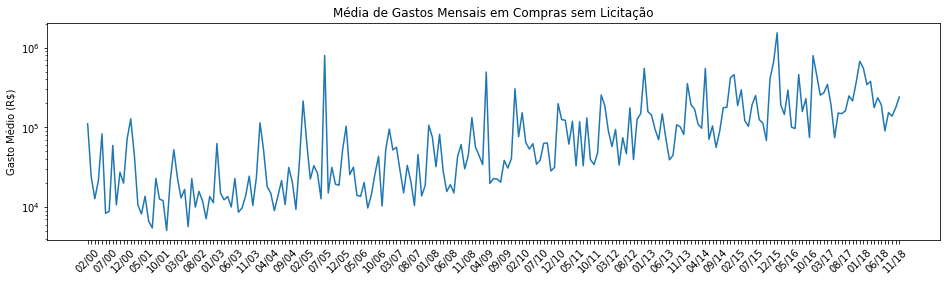

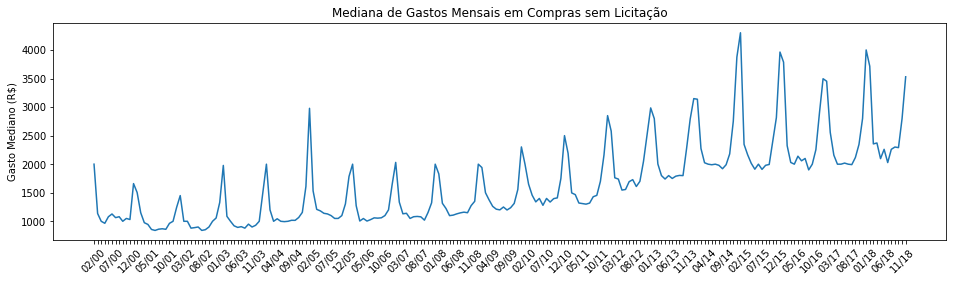

In [7]:
plt.figure(figsize=(16,4))
plt.plot(df['mean'])
plt.title('Média de Gastos Mensais em Compras sem Licitação')
plt.yscale('log')
plt.ylabel('Gasto Médio (R$)')
plt.xticks(range(df.shape[0]), [str(pd.to_datetime(d).month).zfill(2) + '/' + str(pd.to_datetime(d).year%2000).zfill(2) if i%5 == 0 else ' ' for i,d in enumerate(df['date'])], rotation = 45)
print()

plt.figure(figsize=(16,4))
plt.plot(df['median'])
plt.ylabel('Gasto Mediano (R$)')
plt.title('Mediana de Gastos Mensais em Compras sem Licitação')
plt.xticks(range(df.shape[0]), [str(pd.to_datetime(d).month).zfill(2) + '/' + str(pd.to_datetime(d).year%2000).zfill(2) if i%5 == 0 else ' ' for i,d in enumerate(df['date'])], rotation = 45)
print()

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:5108: ComplexWarning: Casting complex values to real discards the imaginary part
  X[0] = start
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:5109: ComplexWarning: Casting complex values to real discards the imaginary part
  X[N + 1] = end
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:5112: ComplexWarning: Casting complex values to real discards the imaginary part
  X[1:N + 1, 1] = y1slice
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:5114: ComplexWarning: Casting complex values to real discards the imaginary part
  X[N + 2:, 1] = y2slice[::-1]
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:827: ComplexWarning: Casting complex values to real discards the imaginary p

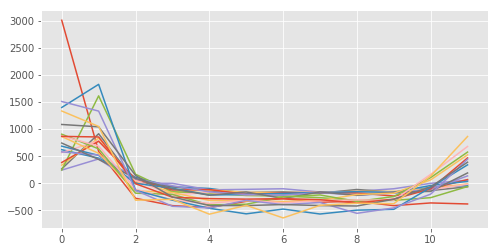

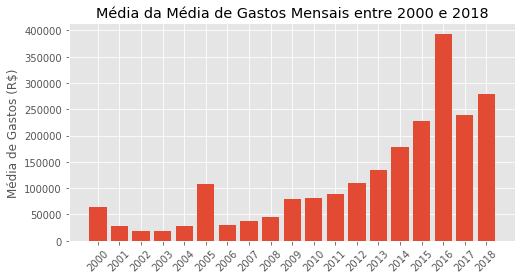

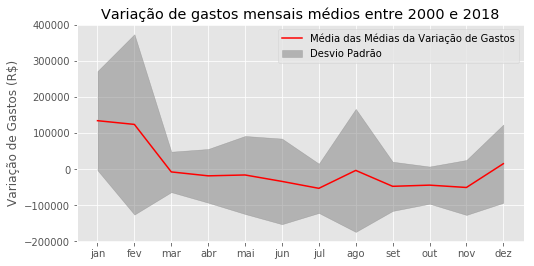

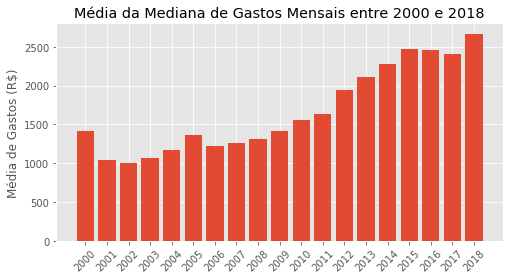

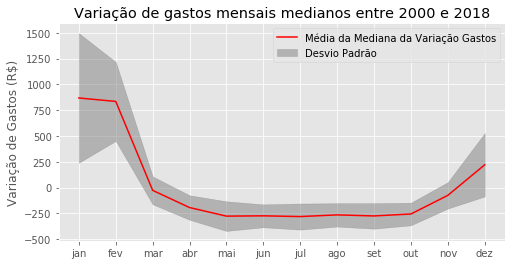

In [8]:
data_median = []
data_mean = []
desloc_mean = []
desloc_median = []

steps = 12

mn = []
plt.style.use('ggplot')
plt.figure(figsize=(8,4))
for i in range(0, 19):
    df = pd.read_csv('1_month_datagov.csv')
    df = df.fillna(0)
    df['date'] = pd.to_datetime(df.date)
    df = df[(df.date >= '01-01-20' + str(i).zfill(2)) & (df.date < '01-01-20' + str(i+1).zfill(2))]
    
    t = df.date.dt.month.values
    x_median = df['median'].values
    x_mean = df['mean'].values
    
    S_mean = CubicSpline(t, x_mean)    
    S_median = CubicSpline(t, x_median)
    
    t = list(range(1,steps+1))
    x_mean = S_mean(t)
    x_median = S_median(t)
    
    plt.plot(fft_decomposition(x_median, steps, get_first = False))
    mn.append(x_median.mean())
    
    data_median.append(fft_decomposition(x_median, steps, get_first = False))
    data_mean.append(fft_decomposition(x_mean, steps, get_first = False))
    desloc_mean.append(fft_get_ith_component(x_mean, 0).real.mean())
    desloc_median.append(fft_get_ith_component(x_median, 0).mean())
    
    
plt.figure(figsize=(8,4))
plt.bar(range(len(desloc_mean)), desloc_mean)
plt.xticks(range(len(desloc_mean)), list(range(2000,2019)), rotation = 45)
plt.ylabel('Média de Gastos (R$)')
plt.title('Média da Média de Gastos Mensais entre 2000 e 2018')


plt.figure(figsize=(8,4))
plt.plot(np.array(data_mean).mean(axis = 0), color = 'red', label = 'Média das Médias da Variação de Gastos')
plt.fill_between(range(steps), 
                 np.array(data_mean).mean(axis = 0) - np.array(data_mean).std(axis = 0),
                 np.array(data_mean).mean(axis = 0) + np.array(data_mean).std(axis = 0), 
                 color = 'grey',
                 alpha = .5, label = 'Desvio Padrão')
plt.xticks(range(steps), ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez'])
plt.title('Variação de gastos mensais médios entre 2000 e 2018')
plt.ylabel('Variação de Gastos (R$)')
plt.legend()

plt.figure(figsize=(8,4))
plt.bar(range(len(desloc_median)), desloc_median)
plt.xticks(range(len(desloc_median)), list(range(2000,2019)), rotation = 45)
plt.ylabel('Média de Gastos (R$)')
plt.title('Média da Mediana de Gastos Mensais entre 2000 e 2018')

plt.figure(figsize=(8,4))
#plt.bar(range(12), np.array(data_median).mean(axis = 0), color = 'red', label = 'Média da Mediana da Variação Gastos')
plt.plot(range(12), np.array(data_median).mean(axis = 0), color = 'red', label = 'Média da Mediana da Variação Gastos')
plt.fill_between(range(steps), 
                 np.array(data_median).mean(axis = 0) - np.array(data_median).std(axis = 0),
                 np.array(data_median).mean(axis = 0) + np.array(data_median).std(axis = 0), 
                 color = 'grey',
                 alpha = .5, label = 'Desvio Padrão')
plt.xticks(range(steps), ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez'])
plt.title('Variação de gastos mensais medianos entre 2000 e 2018')
plt.ylabel('Variação de Gastos (R$)')
plt.legend()

In [9]:
t1 = np.array(range(2000, 2019))
x1 = np.array(desloc_median).real

t2 = np.array(range(1, 13))
x2 = np.array(data_median).real

In [10]:
new_x2 = []
new_t2 = []
for temp in x2:
    new_x2 += list(temp)
    new_t2 += list(t2)

In [70]:
points = list(zip(t1, x1))
#points = list(zip(new_t2, new_x2))
#points = [(np.array([a]),np.array([b])) for a,b in points]
points_test = points[int(0.7*len(points))-3:]
points = points[0:int(0.7*len(points))-3]

In [71]:
N_INPUTS = 1

In [72]:
def div(left, right):
    if right != 0:
        return left / right
    return 1

def log(x):
    if x != 0:
        return np.log(np.abs(x))
    else:
        return 1
    
def sqrt(x):
    return np.abs(x)**.5

########## Operator Set #########################################
pset = gp.PrimitiveSet("MAIN", N_INPUTS)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(div, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(sqrt, 1)
pset.addPrimitive(log, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
#################################################################
#pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.addTerminal(2000)
pset.addTerminal(3.14)
pset.addTerminal(1000)
pset.addTerminal(0)
pset.addTerminal(1)
pset.addTerminal(60)
#pset.renameArguments(ARG0='x')

In [73]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

/usr/local/lib/python3.5/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [74]:
def relative_error(true, pred):
    return (sum((true-pred)**2))/(sum((true - true.mean())**2))

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    f_approx = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression and the real function
    
    y_true = []
    y_pred = []
    for x, y in points:
        try:
            y_true.append(y)
            if type(x) in (list, type(np.array([1]))):
                y_pred.append(f_approx(*x))
            else:
                y_pred.append(f_approx(x))
        except ValueError:
            return 1e30,

    return np.mean((np.array(y_true)-np.array(y_pred))**2),
    #try:
        #return relative_error(np.array(y_true), np.array(y_pred)),
    #except Exception as e:
    #    return 1e30,

In [75]:
def evalSymbReg2(individual, points):
    # Transform the tree expression in a callable function
    f_approx = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression and the real function
    
    y_true = []
    y_pred = []
    for x, y in points:
        try:
            y_true.append(y)
            if type(x) in (list, type(np.array([1]))):
                y_pred.append(f_approx(*x))
            else:
                y_pred.append(f_approx(x))
        except ValueError:
            return 1e30,
    return y_true, y_pred

In [76]:
def evalSymbReg3(individual, x):
    # Transform the tree expression in a callable function
    f_approx = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression and the real function
    try:
        return f_approx(*x)
    except ValueError:
        return 1e30

In [77]:
TAM_MAX = 10
NPOP = 300
CXPB = .85
MUTPB = .15
NGEN = 200

In [78]:
toolbox.register("evaluate", evalSymbReg, points = points)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=4)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
#toolbox.register("mutate", gp.mutShrink)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value = TAM_MAX))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value = TAM_MAX))

start = time.time()

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(lambda ind: ind.height)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop = toolbox.population(NPOP)
hof = tools.HallOfFame(1)

def fmate(children):
    if random.random() < CXPB:
        children = toolbox.mate(children[0], children[1])
        del children[0].fitness.values
        del children[1].fitness.values
    return children[0], children[1]

def fmutate(mutant):
    if random.random() < MUTPB:
        mutant = toolbox.mutate(mutant)[0]
        del mutant.fitness.values
    return mutant

In [79]:
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit
    if (math.isnan(fit[0])):
            ind.fitness.values = 1e30,
    else:
        ind.fitness.values = fit

log = tools.Logbook()
hof = tools.selBest(pop, 1)

In [24]:
USE_MULTIPROCESSING = 0

In [390]:
print(">> Regressao Numerica com GP: ")
for g in range(NGEN):
    geninit = time.time()
    pop = toolbox.select(pop, len(pop))

    #print(1)
    if USE_MULTIPROCESSING > 0:
        offspring = list(p.map(toolbox.clone, pop))
        offspring = p.map(fmate, list(zip(offspring[::2], offspring[1::2])))
        offspring = [xx for sub in offspring for xx in sub]
        offspring = p.map(fmutate, offspring)
        fitnesses = p.map(toolbox.evaluate, offspring)
    else:
        offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)
        fitnesses = list(map(toolbox.evaluate, offspring))
    
    #print(2)
    for ind, fit in zip(offspring, fitnesses):
        if (math.isnan(fit[0])):
            ind.fitness.values = 1e30,
        else:
            ind.fitness.values = fit

    #print(3)
    hof = tools.selBest(pop, 1)
    pop[:] = offspring + hof

    log.record(gen = g, time = time.time() - geninit,**mstats.compile(pop))
    print(log.stream)


end = time.time()
print((end-start)/60)

>> Regressao Numerica com GP: 
   	        	                      fitness                      	              size             
   	        	---------------------------------------------------	-------------------------------
gen	time    	avg        	max        	min   	std        	avg    	max	min	std    
0  	0.520069	8.34061e+08	2.42847e+11	191910	1.39765e+10	2.61794	9  	1  	1.48197
1  	0.508424	3.35929e+09	1e+12      	191910	5.74514e+10	2.91391	9  	1  	1.71646
2  	0.583066	5.19262e+07	1.49862e+10	191910	8.59939e+08	3.48845	11 	1  	1.98651
3  	0.676805	1.18453e+13	3.6e+15    	191910	2.06134e+14	3.73684	11 	1  	2.07186
4  	0.819271	5.54164e+27	1.6902e+30 	184762	9.66218e+28	4.22951	12 	1  	2.25573
5  	0.943597	7.49122e+08	1.41528e+11	158484	9.44495e+09	4.45752	12 	1  	2.45345
6  	0.992929	6.8988e+10 	1.6e+13    	158484	9.39947e+11	4.92834	12 	1  	2.53215
7  	1.0835  	4.2747e+16 	1.31661e+19	148793	7.48987e+17	5.27922	12 	1  	2.51746
8  	1.34448 	7.91892e+09	1.38573e+12	148793	9.44567e+10

In [25]:
y1, y2 = evalSymbReg2(hof[0], points)

In [26]:
print(hof[0])

div(add(div(mul(3.14, 60), ARG0), div(0, ARG0)), div(log(3.14), sub(log(1000), 1)))


In [28]:
p_train = np.array([b for a, b in points]).reshape(len(points)//12, 12)
p_test = np.array([b for a, b in points_test]).reshape(len(points_test)//12, 12)

In [56]:
HOF_MES = txt_to_individual(file_path='hof_mes.txt', pset=pset)
HOF_MES_simplified = '-60*log(sqrt(Abs(ARG0))) - 60*sqrt(Abs(ARG0)) + sqrt(Abs(ARG0 - 57986.78033775 - 3*log(10) + 120000/sqrt(Abs(ARG0)) + 120000/(ARG0*sqrt(Abs(ARG0)))))/(ARG0*log(Abs(ARG0/(log(sqrt(Abs(ARG0))) - 3*log(10)) + 3.14))) + sqrt(Abs(2*5**(3/4) + 7320 + sqrt(10)*sqrt(Abs(ARG0))/(100*(ARG0**2 + ARG0/2000)) - 19990*sqrt(10)/(ARG0**2 + ARG0/2000) - 120000/ARG0**2))/(ARG0*log(Abs(ARG0 - 3.14)))'
#file = open('hof_mes.txt', 'w')
#file.write(str(HOF_MES))
#file.close()

In [68]:
HOF_ANO = txt_to_individual(file_path='hof_ano_1-Copy1.txt', pset=pset)
HOF_ANO_simplified = 'sqrt(5)*sqrt(Abs(ARG0**4*sin(8000)*cos(cos(sqrt(Abs(ARG0 - 2000)))) - 3996.929203673205*ARG0**3*sin(8000)*cos(cos(sqrt(Abs(ARG0 - 2000)))) + 3994859.692744574*ARG0**2*sin(8000)*cos(cos(sqrt(Abs(ARG0 - 2000)))) - 5570.796326794897*ARG0**2 - 1999500*ARG0*sin(8000)*cos(cos(sqrt(Abs(ARG0 - 2000)))) + 5141592.653589793*ARG0 + 11970998429.20367))/(50*sqrt(Abs(cos(cos(sqrt(Abs(ARG0 - 2000))))))) + 1000'

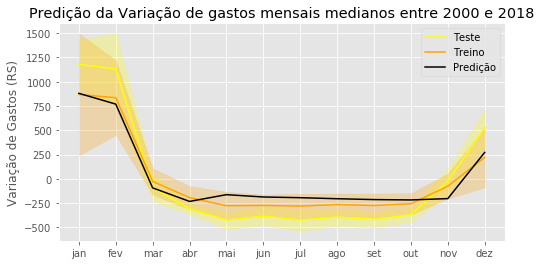

In [116]:
f_approx = toolbox.compile(expr=HOF_MES)

plt.figure(figsize=(8,4))
plt.fill_between(range(1,13), p_test.mean(axis = 0)+p_test.std(axis = 0), p_test.mean(axis = 0)-p_test.std(axis = 0), color = 'yellow', alpha = .25)
plt.plot(range(1,13), p_test.mean(axis = 0), color = 'yellow', alpha = 1, label = 'Teste')
plt.fill_between(range(1,13), p_train.mean(axis = 0)-p_train.std(axis = 0), p_train.mean(axis = 0)+p_train.std(axis = 0), color = 'orange', alpha = .25)
plt.plot(range(1,13), p_train.mean(axis = 0), alpha = 1, label = 'Treino', color = 'orange')
plt.plot(range(1,13), [f_approx(i) for i in range(1,13)], alpha = 1, color = 'black', label = 'Predição')

plt.xticks(list(range(1,13)), ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez'])
plt.title('Predição da Variação de gastos mensais medianos entre 2000 e 2018')
plt.ylabel('Variação de Gastos (RS)')
plt.legend()
plt.savefig('prediction_mes_compras.png')


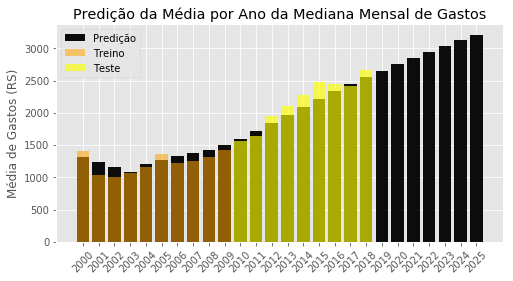

In [86]:
f_approx = toolbox.compile(expr=HOF_ANO)

plt.figure(figsize=(8,4))
plt.bar(range(2000,2026), [f_approx(i) for i in range(2000,2026)], alpha = .95, color = 'black', label = 'Predição')
plt.bar(range(2000, 2000+len(points)), [b for a,b in points], alpha = .55, label = 'Treino', color = 'orange')
plt.bar([a for a, b in points_test], [b for a,b in points_test], color = 'yellow', alpha = .65, label = 'Teste')
plt.xticks(range(2000,2026), list(range(2000,2026)), rotation = 45)
plt.title('Predição da Média por Ano da Mediana Mensal de Gastos')
plt.ylabel('Média de Gastos (RS)')
plt.legend()
#plt.savefig('prediction_ano_compras1.png')

In [94]:
f_approx = toolbox.compile(expr=HOF_MES)
data_m = np.array([f_approx(i) for i in range(1,13)]*26)

f_approx = toolbox.compile(expr=HOF_ANO)
data_y = np.array([[f_approx(i)]*12 for i in range(2000,2026)]).reshape(26*12)

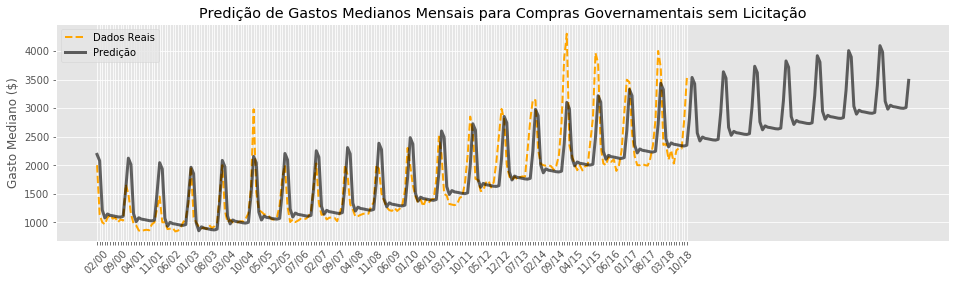

In [125]:
df = pd.read_csv('1_month_datagov.csv')
df = df.fillna(0)
df['date'] = pd.to_datetime(df.date)

plt.figure(figsize=(16,4))
plt.plot(df['median'], '--', linewidth = 2, color = 'orange', label = 'Dados Reais')
plt.xticks(range(df.shape[0]), [str(pd.to_datetime(d).month).zfill(2) + '/' + str(pd.to_datetime(d).year%2000).zfill(2) if i%7 == 0 else ' ' for i,d in enumerate(df['date'])], rotation = 45)

plt.plot(data_m+data_y, linewidth = 3, color = 'black', label = 'Predição', alpha = .6)
plt.title('Predição de Gastos Medianos Mensais para Compras Governamentais sem Licitação')
plt.ylabel('Gasto Mediano ($)')
plt.legend()
plt.savefig('final_prediction.png')

In [82]:
f_approx = toolbox.compile(expr=HOF_ANO)
f_approx(2000)

1308.3822477858237

In [65]:
str(HOF_MES)

'div(add(div(sqrt(sub(add(60, add(mul(60, 60), add(60, add(mul(60, 60), sqrt(sqrt(2000)))))), add(div(div(mul(2000, 60), ARG0), ARG0), div(sub(neg(sqrt(ARG0)), mul(sub(2000, 1), neg(1000))), mul(sub(div(ARG0, add(2000, mul(2000, 0))), mul(ARG0, neg(ARG0))), sqrt(1000)))))), log(add(mul(ARG0, 1), neg(3.14)))), add(div(sqrt(sub(add(add(neg(sub(div(0, 2000), sub(log(1000), 2000))), sqrt(sub(neg(2000), mul(3.14, 60)))), mul(2000, 0)), add(div(add(div(mul(2000, 60), ARG0), mul(2000, 60)), sqrt(ARG0)), add(ARG0, add(mul(60, neg(1000)), 60))))), log(add(div(neg(ARG0), sub(log(1000), log(neg(sqrt(ARG0))))), neg(neg(3.14))))), add(mul(ARG0, neg(mul(60, log(neg(sqrt(ARG0)))))), mul(neg(sqrt(ARG0)), mul(ARG0, 60))))), ARG0)'

In [118]:
#file = open('hof_ano_1.txt', 'w')
#file.write(str(HOF_ANO))
#file.close()

In [126]:
HOF2 = txt_to_individual(file_path='hof_ano_1-Copy1.txt', pset=pset)

In [127]:
from sympy import simplify, expand
from deap import gp
import operator

#from .evaluation import fitness
#from .operator_set import *

import matplotlib.pyplot as plt
import networkx as nx

def gmean(a,b):
    return('(({}*{})**2)'.format(a,b))

def mmean(a,b):
    return('(({}+{})/2)'.format(a,b))

def add(a,b):
    return('({} + {})'.format(a,b))

def neg(a):
    return('(-{})'.format(a))

def log(a):
    return('log(Abs({}))'.format(a))

def sqrt(a):
    return('sqrt(Abs({}))'.format(a))

def sin(a):
    return('sin({})'.format(a))

def cos(a):
    return('cos({})'.format(a))

def sub(a,b):
    return('({} - {})'.format(a,b))

def div(a,b):
    return('({} / {})'.format(a,b))

def div(a,b):
    return('({} / {})'.format(a,b))

def mul(a,b):
    return('({} * {})'.format(a,b))

def F(a):
    return('{}'.format(a))

def txt_to_individual(file_path, pset):
    file = open(file_path, 'r')
    string = file.read()
    file.close()

    #string.replace('div', 'pdiv')
    #string.replace('sqrt', 'psqrt')
    #string.replace('log', 'plog')
    expr = gp.genFull(pset, min_=1, max_=3)
    tree = gp.PrimitiveTree(expr)
    individual = tree.from_string(string, pset)
    return individual

def convertFunct(string):
    ARG0 = 'ARG0'
    ARG1 = 'ARG1'
    ARG2 = 'ARG2'
    ARG3 = 'ARG3'
    ARG4 = 'ARG4'
    ARG5 = 'ARG5'
    ARG6 = 'ARG6'
    ARG7 = 'ARG7'
    ARG8 = 'ARG8'
    ARG9 = 'ARG9'
    ARG10 = 'ARG10'
    ARG11 = 'ARG11'
    ARG12 = 'ARG12'
    ARG13 = 'ARG13'
    ARG14 = 'ARG14'
    ARG15 = 'ARG15'
    ARG16 = 'ARG16'
    ARG17 = 'ARG17'
    ARG18 = 'ARG18'
    ARG19 = 'ARG19'
    ARG20 = 'ARG20'
    ARG21 = 'ARG21'
    ARG22 = 'ARG22'
    ARG23 = 'ARG23'
    ARG24 = 'ARG24'
    ARG25 = 'ARG25'
    ARG26 = 'ARG26'
    ARG27 = 'ARG27'
    ARG28 = 'ARG28'
    ARG29 = 'ARG29'
    ARG30 = 'ARG30'
    ARG31 = 'ARG31'
    ARG32 = 'ARG32'
    ARG33 = 'ARG33'
    ARG34 = 'ARG34'
    ARG35 = 'ARG35'
    ARG36 = 'ARG36'
    ARG37 = 'ARG37'
    ARG38 = 'ARG38'
    ARG39 = 'ARG39'
    ARG40 = 'ARG40'
    ARG41 = 'ARG41'
    ARG42 = 'ARG42'
    ARG43 = 'ARG43'
    ARG44 = 'ARG44'
    ARG45 = 'ARG45'
    ARG46 = 'ARG46'
    ARG47 = 'ARG47'
    ARG48 = 'ARG48'
    ARG49 = 'ARG49'
    ARG50 = 'ARG50'
    ARG51 = 'ARG51'
    ARG52 = 'ARG52'
    ARG53 = 'ARG53'
    ARG54 = 'ARG54'
    ARG55 = 'ARG55'
    ARG56 = 'ARG56'
    ARG57 = 'ARG57'
    ARG58 = 'ARG58'
    ARG59 = 'ARG59'
    ARG60 = 'ARG60'
    ARG61 = 'ARG61'
    ARG62 = 'ARG62'
    ARG63 = 'ARG63'
    ARG64 = 'ARG64'
    ARG65 = 'ARG65'
    ARG66 = 'ARG66'
    ARG67 = 'ARG67'
    ARG68 = 'ARG68'
    ARG69 = 'ARG69'
    ARG70 = 'ARG70'
    ARG71 = 'ARG71'
    ARG72 = 'ARG72'
    ARG73 = 'ARG73'
    ARG74 = 'ARG74'
    ARG75 = 'ARG75'
    return eval(string)

def get_equations_simplified(individual):
    string = str(individual)
    ind = [i for i in range(len(string)) if string.startswith('F', i)]
    features = []
    for i in ind:
        subtree = fitness.get_subtree(i,string)
        features.append(subtree)
    if len(features) == 0:
        features.append(string)
    eqs = []
    for eq in features:
        temp = expand(simplify(convertFunct(eq)))
        eqs.append(temp)
    return eqs
    

def plot_tree(individual, save_file = True, path = 'tree.pdf'):
    nodes, edges, labels = gp.graph(individual)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog="dot")

    nx.draw_networkx_nodes(g, pos, node_color='lightgray',node_size=3000)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels, font_size=16)

    plt.rcParams["figure.figsize"] = [25,16]
    plt.margins(.1,.1)    
    plt.axis('off')
    
    if save_file:
        plt.savefig(path)
    
    plt.show()
    return

In [133]:
import sympy

convertFunct(str(HOF_MES))
res = expand(simplify(expand(convertFunct(str(HOF_MES)))))
print(res)
print()
_ = [print(r) for r in res.args]
args = res.args

-60*log(sqrt(Abs(ARG0))) - 60*sqrt(Abs(ARG0)) + sqrt(Abs(ARG0 - 57986.78033775 - 3*log(10) + 120000/sqrt(Abs(ARG0)) + 120000/(ARG0*sqrt(Abs(ARG0)))))/(ARG0*log(Abs(ARG0/(log(sqrt(Abs(ARG0))) - 3*log(10)) + 3.14))) + sqrt(Abs(2*5**(3/4) + 7320 + sqrt(10)*sqrt(Abs(ARG0))/(100*(ARG0**2 + ARG0/2000)) - 19990*sqrt(10)/(ARG0**2 + ARG0/2000) - 120000/ARG0**2))/(ARG0*log(Abs(ARG0 - 3.14)))

-60*sqrt(Abs(ARG0))
-60*log(sqrt(Abs(ARG0)))
sqrt(Abs(2*5**(3/4) + 7320 + sqrt(10)*sqrt(Abs(ARG0))/(100*(ARG0**2 + ARG0/2000)) - 19990*sqrt(10)/(ARG0**2 + ARG0/2000) - 120000/ARG0**2))/(ARG0*log(Abs(ARG0 - 3.14)))
sqrt(Abs(ARG0 - 57986.78033775 - 3*log(10) + 120000/sqrt(Abs(ARG0)) + 120000/(ARG0*sqrt(Abs(ARG0)))))/(ARG0*log(Abs(ARG0/(log(sqrt(Abs(ARG0))) - 3*log(10)) + 3.14)))


In [134]:
convertFunct(str(HOF_ANO))
res = expand(simplify(expand(convertFunct(str(HOF_ANO)))))
print(res)
print()
_ = [print(r) for r in res.args]
args = res.args

sqrt(5)*sqrt(Abs(ARG0**4*sin(8000)*cos(cos(sqrt(Abs(ARG0 - 2000)))) - 3996.93*ARG0**3*sin(8000)*cos(cos(sqrt(Abs(ARG0 - 2000)))) + 3994861.285*ARG0**2*sin(8000)*cos(cos(sqrt(Abs(ARG0 - 2000)))) - 5570.0*ARG0**2 - 1999500*ARG0*sin(8000)*cos(cos(sqrt(Abs(ARG0 - 2000)))) + 5140000.0*ARG0 + 11970998430.0))/(50*sqrt(Abs(cos(cos(sqrt(Abs(ARG0 - 2000))))))) + 1000

1000
sqrt(5)*sqrt(Abs(ARG0**4*sin(8000)*cos(cos(sqrt(Abs(ARG0 - 2000)))) - 3996.93*ARG0**3*sin(8000)*cos(cos(sqrt(Abs(ARG0 - 2000)))) + 3994861.285*ARG0**2*sin(8000)*cos(cos(sqrt(Abs(ARG0 - 2000)))) - 5570.0*ARG0**2 - 1999500*ARG0*sin(8000)*cos(cos(sqrt(Abs(ARG0 - 2000)))) + 5140000.0*ARG0 + 11970998430.0))/(50*sqrt(Abs(cos(cos(sqrt(Abs(ARG0 - 2000)))))))


In [142]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_tree(individual, save_file = True, path = 'tree.pdf'):
    nodes, edges, labels = gp.graph(individual)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog="dot")

    nx.draw_networkx_nodes(g, pos, node_color='lightgray',node_size=3000)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels, font_size=16)

    plt.rcParams["figure.figsize"] = [48,24]
    plt.margins(.1,.1)    
    plt.axis('off')
    
    if save_file:
        plt.savefig(path)
    
    plt.show()
    return

/usr/local/lib/python3.5/dist-packages/networkx-2.1-py3.5.egg/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


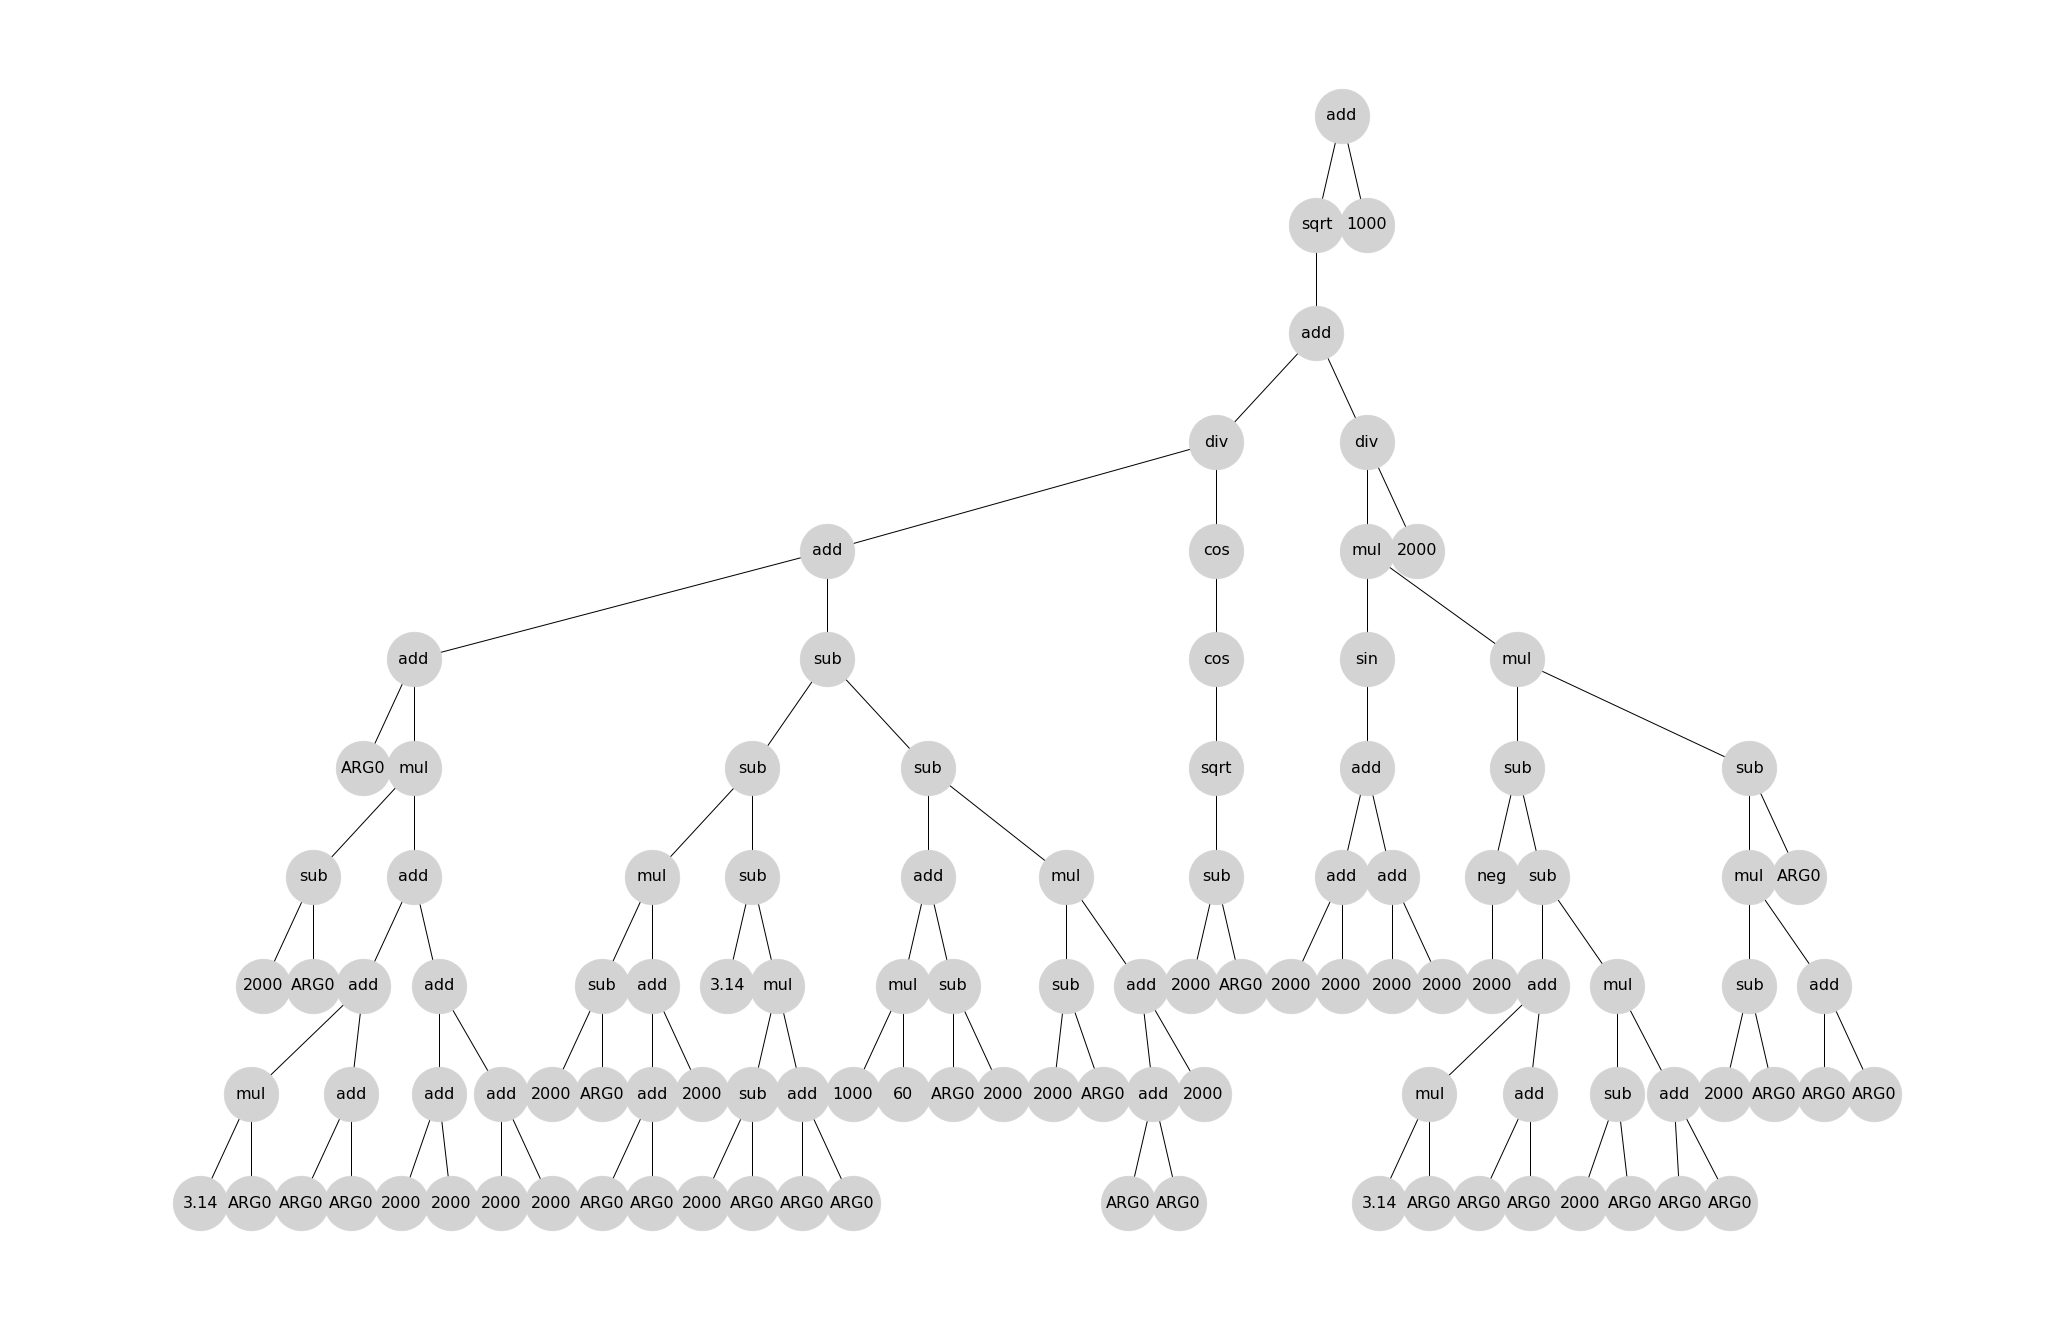

In [143]:
plot_tree(HOF2)